## Michigan Emergency Department Flow Optimization

There are **high patient volumes** at the ED with increasing patient wait times. Can we _simulate_ various optimization strategies such as **split-flow** and **vertical-flow** models to identify the best way to allocate resources.

_Goal:_ Use Discrete Event Simulation (DES) to simulate current Michigan ER flow and compare it with proposed optimization methods.

In [3]:
import simpy
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

%matplotlib inline

### Learning SimPy

Sample code for learning simpy.

Useful resources:
- [Real Python Theater Example](https://realpython.com/simpy-simulating-with-python/)
- [SimPy Carwash](https://simpy.readthedocs.io/en/latest/examples/carwash.html)
- [Emergency Dept Example Model](https://github.com/MichaelAllen1966/1804_python_healthcare/blob/master/jupyter_notebooks/0062_ed_model_1.ipynb)
- [Bed Occupancy Example Model](https://github.com/MichaelAllen1966/1804_python_healthcare/blob/master/jupyter_notebooks/0060_simpy_beds_1.ipynb)
- [Python For Healthcare](https://pythonhealthcare.org/2018/04/13/60-simpy-a-simple-bed-occupancy-model/)

In [45]:
def patient(env, name, screening_time, triage_beds, triage_time):
    # simulate getting initial screening
    print(f'{name} getting screened at {env.now}')
    yield env.timeout(screening_time)
    
    # request a bed to get triaged
    with triage_beds.request() as req:
        print(f'{name} waiting to be triaged at {env.now}')
        yield req
    
        # get triaged
        print(f'{name} being triaged at {env.now}')
        yield env.timeout(triage_time)
        print(f'{name} finished being triaged at {env.now}')

In [46]:
env = simpy.Environment()
triage_beds = simpy.Resource(env, capacity=6)

for i in range(8):
    env.process(patient(env, f'Patient {i}', i*2, triage_beds, 30))

In [ ]:
env.run()

### Building A Basic SimPy ED model

This simulation of the emergency department is based off of the _pythonhealthcare.org_ website.

In [331]:
# Simulation Parameters
RANDOM_SEED = 42
TRIAGE_BEDS = 6
TREATMENT_BEDS = 35
HOLDING_BEDS = 9
TIME_ITER = 5 # patients come every 5 mins
SIM_TIME = 1440 # run for 1 whole day (in minutes)
WARM_UP = 60 # time before reading audits
AUDIT_ITER = 10 # how often to audit 

In [332]:
# Globals for auditing simulation
class g():
    patients = [] # list of all patients

    # list index should match audit_time
    audit_time = []
    appointment_time_mean = 100
    appointment_time_sd = 25
    
    # tracking triage properties
    triage_wait_counter = 0 # count waiting for triage (currently)
    triage_pt_waiting = [] # track over time
    triage_waiting_prior_counter = [0, 0, 0] # waiting by priority
    triage_pt_waiting_prior = []

    
    triage_occupancy_prior = [0, 0, 0]
    triage_occupancy = [] # number of beds occupied 
    
    
    
    # tracking treatment properties 
    treat_wait_counter = 0 # count waiting for treatment (currently)
    treat_pt_waiting = [] # track over time
    treat_waiting_prior_counter = [0, 0, 0] # waiting by priority
    treat_pt_waiting_prior = []
    
  
    treat_occupancy_prior = [0, 0, 0]
    treat_occupancy = [] # number of beds occupied

In [333]:
# Define data structures
class Patient:
    def __init__(self, env, name, prior):
        self.name = name
        self.prior = prior
        
        self.treat_time = random.normalvariate(g.appointment_time_mean, g.appointment_time_sd) # how long it'll take to tx patient
        
        self.treat_time = 0 if self.treat_time < 0 else self.treat_time
        self.arrival_time = env.now
        self.discharge_time = None
        self.queuing_time = 0

        self.waiting = 1
        self.location = ''


class EmergencyDepartment:
    def __init__(self, env, triage_beds, treat_beds, holding_beds):
        self.env = env
        
        # resources 
        # self.waiting_room_beds = simpy.Resource(env, init=20, capacity=100)
        self.triage_beds = simpy.PriorityResource(env, capacity=triage_beds) # represents number of beds @ each location
        self.treatment_beds = simpy.PriorityResource(env, capacity=treat_beds)
        self.holding_beds = simpy.PriorityResource(env, capacity=holding_beds)

        
    def screen(self, patient):
        yield self.env.timeout(15)
        
    def triage(self, patient):
        yield self.env.timeout(25)
        
    def treat(self, patient):
        yield self.env.timeout(patient.treat_time) # make this random

        
    
class VTZ(EmergencyDepartment):
    pass

In [334]:
# Define patient flow through ed 
def go_to_ed(env, patient, ed):
    # arrives at ed 
    yield env.process(ed.screen(patient))
    
    
    g.triage_wait_counter += 1
    g.triage_waiting_prior_counter[patient.prior-1] += 1
    
    # request for triage bed or wait in waiting room
    with ed.triage_beds.request(priority=patient.prior) as req: 
        yield req
            
        # triage patient
        g.triage_wait_counter -= 1
        g.triage_waiting_prior_counter[patient.prior-1] -= 1
        g.triage_occupancy_prior[patient.prior-1] +=1
        
#         print(f'triage occupied: {ed.triage_beds.count}')
        yield env.process(ed.triage(patient))
        
        g.triage_occupancy_prior[patient.prior-1] -=1


    
    
    g.treat_wait_counter += 1
    g.treat_waiting_prior_counter[patient.prior-1] += 1
    
    # go to treatment room OR wait in waiting room
    with ed.treatment_beds.request(priority=patient.prior) as req:
        yield req
        
        # treat patient
        g.treat_wait_counter -= 1 
        g.treat_waiting_prior_counter[patient.prior-1] -= 1
        g.treat_occupancy_prior[patient.prior-1] += 1
        
#         print(f'treatment occupied: {ed.treatment_beds.count}')
        yield env.process(ed.treat(patient))
        
        g.treat_occupancy_prior[patient.prior-1] -= 1
        
        # patient gets discharged/admitted
        patient.discharge_time = env.now
        patient.queuing_time = patient.discharge_time - patient.arrival_time

In [335]:
# main handlers
def run_ed(env, ed, num_triage, num_treat, num_hold, t_inter):
    """
    Runs through the simulated Michigan ED
    """
    
    # Create ED 
#     ed = EmergencyDepartment(env, num_triage, num_treat, num_hold)
    
    # Create 3 initial patients
    for i in range(3):
        patient = Patient(env, f'Patient {i}', i%3)
        g.patients.append(patient)

        env.process(go_to_ed(env, patient, ed))
        
    # Create more patients while simulation is running
    while True:
        yield env.timeout(random.randint(t_inter - 2, t_inter + 2))
        i += 1
        patient = Patient(env, f'Patient {i}', (i%3)+1)
        g.patients.append(patient)
        
        env.process(go_to_ed(env, patient, ed))
        

             
def perform_audit(env, ed, warm_up, audit_iter):
        """Monitors modelled ED at regular intervals (as defined by audit 
        interval in global_vars)"""

        # Delay before first aurdit if length of warm-up
        yield env.timeout(warm_up)
        
        # The trigger repeated audits
        while True:
            # Record time
            g.audit_time.append(env.now)
            
            # record data for triage patients
            g.triage_pt_waiting.append(g.triage_wait_counter)
            g.triage_pt_waiting_prior.append(g.triage_waiting_prior_counter)
            
            g.triage_occupancy.append(ed.triage_beds.count)
#             g.triage_occupancy.append(g.triage_occupancy_prior)
            
            
            # record data for treatment patients 
            g.treat_pt_waiting.append(g.treat_wait_counter)
            g.treat_pt_waiting_prior.append(g.treat_waiting_prior_counter)
         
            g.treat_occupancy.append(ed.treatment_beds.count)
#             g.treat_occupancy.append(g.treat_occupancy_prior)
            
            
            # Trigger next audit after interval
            yield env.timeout(audit_iter)

In [336]:
# Setup the simulation environment
print('Emergency Department')
random.seed(RANDOM_SEED)

# create environment
env = simpy.Environment()

# # create place
ed = EmergencyDepartment(env, TRIAGE_BEDS, TREATMENT_BEDS, HOLDING_BEDS)

env.process(run_ed(env, ed, TRIAGE_BEDS, TREATMENT_BEDS, HOLDING_BEDS, TIME_ITER)) # run main ed
env.process(perform_audit(env, ed, WARM_UP, AUDIT_ITER)) # capture audits

Emergency Department


<Process(perform_audit) object at 0x7f9a042450d0>

In [337]:
# Run Simulation 
env.run(until=SIM_TIME)

### Build Graphs For SimPy ED model

In [338]:
# Get the occupancy data captured regular audit intervals
data_columns = {'audit_time': g.audit_time, 'triage_occupancy': g.triage_occupancy, 'treatment_occupancy': g.treat_occupancy}

# build df
df = pd.DataFrame(data_columns)
df.triage_occupancy = df.triage_occupancy / TRIAGE_BEDS
df.treatment_occupancy = df.treatment_occupancy / TREATMENT_BEDS

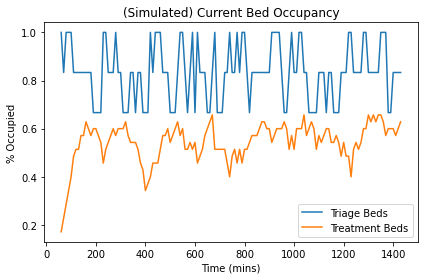

In [339]:
# plot percent occupied over length of simulation
ax = df.plot.line(x='audit_time', title='(Simulated) Current Bed Occupancy')
ax.legend(['Triage Beds', 'Treatment Beds'])
ax.set_xlabel('Time (mins)')
ax.set_ylabel('% Occupied')
plt.tight_layout()
plt.savefig('../reports/figures/current.png', dpi=300) # save fig

In [343]:
# get wait times
from collections import defaultdict

pt_q_time = defaultdict(list)

for p in g.patients:

    if p.prior == 1:
        pt_q_time['pt1'].append(p.queuing_time)
    elif p.prior == 2:
        pt_q_time['pt2'].append(p.queuing_time)
    else:
        pt_q_time['pt3'].append(p.queuing_time)
        
pt1 = pd.DataFrame({'pt': ['pt1' for _  in range(len(pt_q_time['pt1']))], 'wait_time': pt_q_time['pt1']})
pt2 = pd.DataFrame({'pt': ['pt2' for _  in range(len(pt_q_time['pt2']))], 'wait_time': pt_q_time['pt2']})
pt3 = pd.DataFrame({'pt': ['pt3' for _  in range(len(pt_q_time['pt3']))], 'wait_time': pt_q_time['pt3']})

In [344]:
combined_pt = pd.concat([pt1, pt2, pt3])

<AxesSubplot:title={'center':'wait_time'}, xlabel='[pt]'>

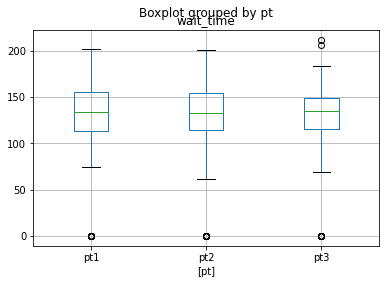

In [352]:
combined_pt.boxplot(by='pt')

<AxesSubplot:xlabel='pt', ylabel='wait_time'>

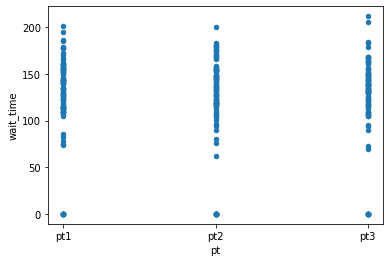

In [348]:
combined_pt.plot.scatter(x='pt', y='wait_time')

### Python Health Care Example

This is the [link](https://pythonhealthcare.org/2018/07/18/89-an-emergency-department-model-in-simpy-with-patient-prioritisation-and-capacity-limited-by-doctor-availability-object-based/) to the blog explaining the code in more detail. Github link [here](https://github.com/MichaelAllen1966/1804_python_healthcare/blob/master/jupyter_notebooks/0062_ed_model_1.ipynb)

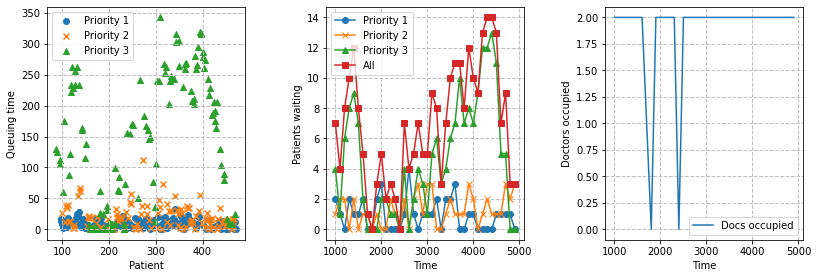

Patient-centred metrics:
------------------------

Lower quartile time in system by priority:
             q_time  consult_time  system_time
priority                                      
1.0        3.724891     14.978744    22.775946
2.0        3.103972     15.550038    23.933966
3.0       37.260593     15.302905    62.466434

Median time in system by priority:
              q_time  consult_time  system_time
priority                                       
1.0         8.889649     19.304001    28.704112
2.0        14.393394     19.346369    34.211169
3.0       161.835057     20.152682   177.858486

Upper quartile time in system by priority:
              q_time  consult_time  system_time
priority                                       
1.0        13.326709     24.797340    35.558707
2.0        26.366220     24.049353    46.260595
3.0       240.780494     24.672182   258.287252

Maximum time in system by priority:
              q_time  consult_time  system_time
priority                  

In [306]:
class Global_vars:
    """Storage of global variables. No object instance created"""
    
    appointment_time_mean = 20
    appointment_time_sd = 7
    audit_time = []
    audit_interval = 100
    audit_patients_in_ED = []
    audit_patients_waiting = []
    audit_patients_waiting_p1 = []
    audit_patients_waiting_p2 = []
    audit_patients_waiting_p3 = []
    audit_reources_used = []
    inter_arrival_time = 10
    number_of_docs = 2
    patient_count = 0
    patients_waiting = 0
    patients_waiting_by_priority = [0, 0, 0]
    patient_queuing_results = pd.DataFrame(columns=['priority', 'q_time', 'consult_time'])
    results = pd.DataFrame()
    sim_duration = 5000
    warm_up = 1000

class Model:
    """ The model object holds the model and the methods directly relevant to the model."""
    
    def __init__(self):
        """Creates instance of SimPy model environemnt"""
        
        self.env = simpy.Environment()

    def build_audit_results(self):
        """Compiles audit results into dataframe held in Glov_vars"""
        
        Global_vars.results['time'] = Global_vars.audit_time
        
        Global_vars.results['patients in ED'] = (
            Global_vars.audit_patients_in_ED)
        
        Global_vars.results['all patients waiting'] = (
            Global_vars.audit_patients_waiting)
        
        Global_vars.results['priority 1 patients waiting'] = (
            Global_vars.audit_patients_waiting_p1)
        
        Global_vars.results['priority 2 patients waiting'] = (
            Global_vars.audit_patients_waiting_p2)
        
        Global_vars.results['priority 3 patients waiting'] = (
            Global_vars.audit_patients_waiting_p3)
        
        Global_vars.results['resources occupied'] = (
            Global_vars.audit_reources_used)

    def chart(self):
        """Plots results at end of run"""
        
        # Define figure size and defintion
        fig = plt.figure(figsize=(12, 4.5))
        # Create two charts side by side

        # Figure 1: patient level results
        ax1 = fig.add_subplot(131)  # 1 row, 3 cols, chart position 1
        x = Global_vars.patient_queuing_results.index
        # Chart loops through 3 priorites
        markers = ['o', 'x', '^']
        for priority in range(1, 4):
            x = (Global_vars.patient_queuing_results[Global_vars.patient_queuing_results
                                                     ['priority'] == priority].index)
            
            y = (Global_vars.patient_queuing_results
                 [Global_vars.patient_queuing_results['priority'] == priority]['q_time'])
            
            ax1.scatter(x, y, marker=markers[priority - 1], label='Priority ' + str(priority))
        ax1.set_xlabel('Patient')
        ax1.set_ylabel('Queuing time')
        ax1.legend()
        ax1.grid(True, which='both', lw=1, ls='--', c='.75')

        # Figure 2: ED level queuing results
        ax2 = fig.add_subplot(132)  # 1 row, 3 cols, chart position 2
        x = Global_vars.results['time']
        y1 = Global_vars.results['priority 1 patients waiting']
        y2 = Global_vars.results['priority 2 patients waiting']
        y3 = Global_vars.results['priority 3 patients waiting']
        y4 = Global_vars.results['all patients waiting']
        ax2.plot(x, y1, marker='o', label='Priority 1')
        ax2.plot(x, y2, marker='x', label='Priority 2')
        ax2.plot(x, y3, marker='^', label='Priority 3')
        ax2.plot(x, y4, marker='s', label='All')
        ax2.set_xlabel('Time')
        ax2.set_ylabel('Patients waiting')
        ax2.legend()
        ax2.grid(True, which='both', lw=1, ls='--', c='.75')

        # Figure 3: ED staff usage
        ax3 = fig.add_subplot(133)  # 1 row, 3 cols, chart position 3
        x = Global_vars.results['time']
        y = Global_vars.results['resources occupied']
        ax3.plot(x, y, label='Docs occupied')
        ax3.set_xlabel('Time')
        ax3.set_ylabel('Doctors occupied')
        ax3.legend()
        ax3.grid(True, which='both', lw=1, ls='--', c='.75')

        # Create plot
        plt.tight_layout(pad=3)
        plt.show()

    def perform_audit(self):
        """Monitors modelled ED at regular intervals (as defined by audit 
        interval in global_vars)"""

        # Delay before first aurdit if length of warm-up
        yield self.env.timeout(Global_vars.warm_up)
        # The trigger repeated audits
        while True:
            # Record time
            Global_vars.audit_time.append(self.env.now)
            # Record patients waiting by referencing global variables
            Global_vars.audit_patients_waiting.append(Global_vars.patients_waiting)
            
            (Global_vars.audit_patients_waiting_p1.append
             (Global_vars.patients_waiting_by_priority[0]))
            
            (Global_vars.audit_patients_waiting_p2.append
             (Global_vars.patients_waiting_by_priority[1]))
            
            (Global_vars.audit_patients_waiting_p3.append
             (Global_vars.patients_waiting_by_priority[2]))
            
            # Record patients waiting by asking length of dictionary of all patients 
            # (another way of doing things)
            Global_vars.audit_patients_in_ED.append(len(Patient.all_patients))
            # Record resources occupied
            Global_vars.audit_reources_used.append(self.doc_resources.docs.count)
            # Trigger next audit after interval
            yield self.env.timeout(Global_vars.audit_interval)

    def run(self):
        """Runs the model: Sets up resources, initialises model process, and starts
        running the model environment. At the end of the run raw model data is saved
        to file, and summary figure and results are displayed."""
        
        # Set up resources
        self.doc_resources = Resources(self.env, Global_vars.number_of_docs)
        # Initialise processes that will run on model run
        self.env.process(self.trigger_admissions())
        self.env.process(self.perform_audit())
        # Run
        self.env.run(until=Global_vars.sim_duration)
        
        # End of simulation run. Build and save results.
        # The saved results are the raw audit data
        Global_vars.patient_queuing_results.to_csv('patient results.csv')
        self.build_audit_results()
        Global_vars.results.to_csv('operational results.csv')
        # Plot a chart of results
        self.chart()
        # Pront text summary of results
        self.summarise()

    def see_doc(self, p):
        """Mangages waiting for doctor resorce. Records time waiting to see doc""" 
        
        with self.doc_resources.docs.request(priority=p.priority) as req:
            Global_vars.patients_waiting += 1
            # Wait for resources to become available
            yield req
            # Resources now available
            # Record queuing times in patient object and Global dataframe
            p.time_see_doc = self.env.now
            p.queuing_time = self.env.now - p.time_in
            _results = [p.priority, p.queuing_time]
            yield self.env.timeout(p.consulation_time)
            _results.append(self.env.now - p.time_see_doc)
            # Record results if warm-up complete
            if self.env.now >= Global_vars.warm_up:
                Global_vars.patient_queuing_results.loc[p.id] = _results
            # Reduce patients waiting counts
            Global_vars.patients_waiting_by_priority[p.priority - 1] -= 1
            Global_vars.patients_waiting -= 1
            # Delete patient (removal from patient dictionary removes only
            # reference to patient and Python then automatically cleans up)
            del Patient.all_patients[p.id]
            
    def summarise(self):
        """Produces displayed text summary of model run"""
        
        # For each patient calaculate time in system as time in queue + time with doc
        Global_vars.patient_queuing_results['system_time'] =  (
                Global_vars.patient_queuing_results['q_time'] +
                Global_vars.patient_queuing_results['consult_time'])
        
        # Disply results summaries
        print ('Patient-centred metrics:')
        print ('------------------------\n')
        print ('Lower quartile time in system by priority:')
        print (Global_vars.patient_queuing_results.groupby('priority').quantile(0.25))
        print ('\nMedian time in system by priority:')
        print (Global_vars.patient_queuing_results.groupby('priority').quantile(0.50))
        print ('\nUpper quartile time in system by priority:')
        print (Global_vars.patient_queuing_results.groupby('priority').quantile(0.75))
        print ('\nMaximum time in system by priority:')
        print (Global_vars.patient_queuing_results.groupby('priority').quantile(1))
        print ('\nED-centred metrics:')
        print ('------------------\n')
        print (Global_vars.results.describe())
        
    def trigger_admissions(self):
        """Produces patient arrivals. Initialises a patient object (from Patient class), 
        passes the patient over to the see_doc method, and sets the next admission
        time/event"""
        
        # While loop continues generating new patients
        while True:
            # Initialise new patient (pass environment to be used to record
            # current simulation time)
            p = Patient(self.env)
            # Add patient to dictionary of patients
            Patient.all_patients[p.id] = p
            # Pass patient to see_doc method
            self.env.process(self.see_doc(p))
            # Sample time for next asmissions
            next_admission = random.expovariate(1 / Global_vars.inter_arrival_time)
            # Schedule next admission
            yield self.env.timeout(next_admission)


class Patient:
    """Class of patient objects. The class also holds a list of all patient objects in 
    all_patients dictionary"""
        
    # The following dictionaries store patients
    all_patients = {}

    # New patient instance
    def __init__(self, env):
        Global_vars.patient_count += 1
        
        self.consulation_time = (
            random.normalvariate(Global_vars.appointment_time_mean,
                                 Global_vars.appointment_time_sd))
        
        self.consulation_time = 0 if self.consulation_time < 0 else self.consulation_time
        self.id = Global_vars.patient_count
        self.priority = random.randint(1, 3)
        self.queuing_time = 0
        self.time_in = env.now
        self.time_see_doc = 0
        self.time_out = 0
        # 1 is subtracted from priority to align priority (1-3) with zero indexed list (0-2)
        Global_vars.patients_waiting_by_priority[self.priority - 1] += 1

class Resources:
    """Resources required by processes in the model.
    Just holds doctors as the only limiting resorce"""
    
    def __init__(self, env, number_of_docs):
        self.docs = simpy.PriorityResource(env, capacity=number_of_docs)

if __name__ == '__main__':
    """Start model running"""
    model = Model() # calls method to set up model envrionment
    model.run() # calls method to run model